CSCD25: Course Project

Reddit had an estimated 303.4 million (https://www.redditinc.com/blog/reddits-2020-year-in-review/) new posts in 2020. It is a social media platform with growing popularity and with that comes better need for structure and organization of the platform. Some Subreddits including r/AskScience use a manual flair method where a mod will assign a topic to a post in order to make organizing, filter and search of the subreddits easier. The goal of the project will be to determine if the current flair system implemented in the subreddit r/AskScience is succeeding, can it be improved and if auto flair detection and assignment could be possible. Beyond this we will try to better understand reddit and r/AskScience as a community. 

 The main questions to be answered are does r/AskScience do a good job of choosing Flairs for thier posts? \
    Additional Research questions include:\
        Can they do a better job?\
        Is the subreddit stagnant, or does it change alot?\
        Do particular fields of study dominant the questions?\
        Are certain flairs often asked by the same person?\

In [57]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics
from sklearn.manifold import TSNE

In [58]:
# Load the Data
text_submissions_raw = pd.read_csv('Flair_Data.csv', dtype={'contest_mode': 'string', 'spoiler': 'string'})
print('Shape: ', text_submissions_raw.shape)
print('Columns: ', text_submissions_raw.columns)
print(text_submissions_raw.head(5))

Shape:  (547651, 25)
Columns:  Index(['author', 'author_fullname', 'contest_mode', 'created_utc', 'domain',
       'edited', 'full_link', 'id', 'is_self', 'link_flair_css_class',
       'link_flair_text', 'locked', 'num_comments', 'over_18', 'permalink',
       'retrieved_on', 'score', 'description', 'spoiler', 'stickied',
       'thumbnail', 'question', 'url', 'year', 'banned'],
      dtype='object')
         author author_fullname contest_mode  created_utc           domain  \
0     [deleted]             NaN         <NA>   1453409889  self.askscience   
1      yetawake        t2_sxngl         <NA>   1453741562  self.askscience   
2     [deleted]             NaN        False   1482954217  self.askscience   
3  doublebassed        t2_fpgtx         <NA>   1463053601  self.askscience   
4        Dicios        t2_fn55m         <NA>   1463053639  self.askscience   

   edited                                          full_link      id  is_self  \
0     0.0  https://www.reddit.com/r/askscienc

In [59]:
import time
# transform created_utc time to a month year format
text_submissions_raw['created_utc'] = text_submissions_raw['created_utc'].apply(lambda x: time.strftime("%Y-%m", time.localtime(int(x))))

The next two code chunks will describe each feature in the dataset and access their value for our research questions

edited values: 
0.000000e+00    533578
1.471154e+09    533579
1.471240e+09    533580
1.471235e+09    533581
1.471220e+09    533582
                 ...  
1.500082e+09    547647
1.500079e+09    547648
1.500074e+09    547649
1.500069e+09    547650
1.485822e+09    547651
Name: edited, Length: 14074, dtype: int64

link_flair_text values: 
Physics                      0.200856
Biology                      0.170421
Human Body                   0.155990
Chemistry                    0.070596
Astronomy                    0.063495
                               ...   
Environmental engineering    0.000002
Materials Science            0.000002
Food Safety AMA              0.000002
🐦 &amp; 🐝                    0.000002
Purple &gt; Pink             0.000002
Name: link_flair_text, Length: 62, dtype: float64

over_18 values: 
False    546167
True       1484
Name: over_18, dtype: int64

num_comments values: 
0       296084
1       122782
2        67400
3        14007
4         7572
         ...  
1318

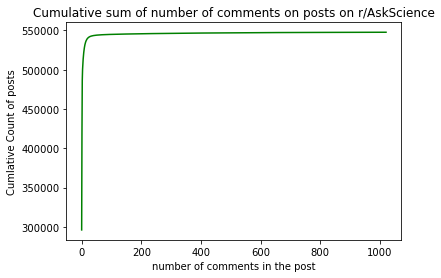


number of posts by years: 
2020    123334
2017    109732
2016    105925
2018     73541
2019     67902
2021     67217
Name: year, dtype: int64

score values: 


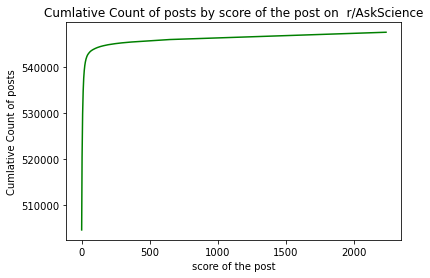


link_flair_css_class values: 

description length summary: 
count    529669.000000
mean         25.456933
std         114.068982
min           1.000000
25%           9.000000
50%           9.000000
75%           9.000000
max       15237.000000
Name: description, dtype: float64

question length summary: 
count    547651.000000
mean         85.628260
std          49.131849
min           1.000000
25%          51.000000
50%          74.000000
75%         108.000000
max         323.000000
Name: question, dtype: float64



In [60]:
# We see most posts are not edited, however there are some posts edited alot. This doesn't seem
# normal and likely some noise or special cases that I'm not famillar with. This need to be explored more
print('edited values: ')
print(np.cumsum(text_submissions_raw.loc[:,'edited'].value_counts()))
print()


# We see only about 14 flairs are used >1% out of the 62 total flairs. To prevent a large number of classifer which are used
# very rarely we will only take the flairs used > 1%
print('link_flair_text values: ')
print(text_submissions_raw.loc[:,'link_flair_text'].value_counts()/np.sum(text_submissions_raw.loc[:,'link_flair_text'].value_counts()))
other_count = np.sum(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[14:])
other = pd.Series([other_count], index=['Other'])
flair_count_other = text_submissions_raw.loc[:,'link_flair_text'].value_counts()[0:14].append(other)
print()

# A large portion of the data is shown to be false, so we may get very little value out of this feature
print('over_18 values: ')
print(text_submissions_raw.loc[:,'over_18'].value_counts())
print()

# A large portion of the data has very low number of comments
print('num_comments values: ')
num_comments = text_submissions_raw.loc[:,'num_comments'].value_counts()
print(num_comments)
plt.plot(np.argsort(np.cumsum(num_comments)), np.cumsum(num_comments), 'g-')
plt.ylabel("Cumlative Count of posts")
plt.xlabel("number of comments in the post")
plt.title('Cumulative sum of number of comments on posts on r/AskScience')
plt.show()
print()

# We see the largest value of posts to be in 2020,2017 and 2016
# This feature may not provide information on how to predict the flair of a post, but
# can provide context to the behaviour of the subreddit over time
print('number of posts by years: ')
print(text_submissions_raw.loc[:,'year'].value_counts())
print()


# Simillar to number of comments a large portion of the data has very low score
print('score values: ')
plt.plot(np.argsort(np.cumsum(text_submissions_raw.loc[:,'score'].value_counts())), np.cumsum(text_submissions_raw.loc[:,'score'].value_counts()), 'g-')
plt.ylabel("Cumlative Count of posts")
plt.xlabel("score of the post")
plt.title('Cumlative Count of posts by score of the post on  r/AskScience')
plt.show()
print()

# We see that the link_flair_css_class is very simillar to the tags of the link_flair_text but in short form
# We see that the top tags in link_flair_text also appear most common in link_flair_css_class. This feature has
# very few outliers
print('link_flair_css_class values: ')
print()

print('description length summary: ')
print(text_submissions_raw.loc[:,'description'].str.len().describe())
print()

print('question length summary: ')
print(text_submissions_raw.loc[:,'question'].str.len().describe())
print()



Value counts posts by author:
[deleted]              49834
thetimujin               174
AskScienceModerator      164
VISHVENDRASIR            149
4000Sjinfotechgroup      133
                       ...  
pene_grande_ghost          1
AtariBasic                 1
nlm96                      1
taeeb11                    1
peacemaker2121             1
Name: author, Length: 303584, dtype: int64



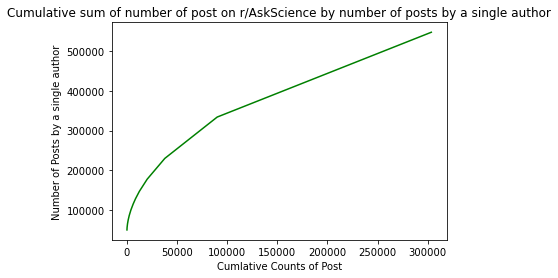

author_fullname samples: 
0         NaN
1    t2_sxngl
2         NaN
Name: author_fullname, dtype: object

Contest_Mode values: 
False    475928
Name: contest_mode, dtype: Int64

id samples: 
0    421zyl
1    42mf5q
2    5ks5kc
Name: id, dtype: object

full_link samples: 
0    https://www.reddit.com/r/askscience/comments/4...
1    https://www.reddit.com/r/askscience/comments/4...
2    https://www.reddit.com/r/askscience/comments/5...
Name: full_link, dtype: object

is_self values: 
True     547591
False        60
Name: is_self, dtype: int64

locked values count: 
False    547337
True        314
Name: locked, dtype: int64

permalink sample: 
0    /r/askscience/comments/421zyl/how_is_time_defi...
1    /r/askscience/comments/42mf5q/how_does_exactly...
2    /r/askscience/comments/5ks5kc/what_would_cause...
Name: permalink, dtype: object

spoiler values: 
False    466532
True        563
Name: spoiler, dtype: Int64

stickied values: 
False    547644
True          7
Name: stickied, dtype: int6

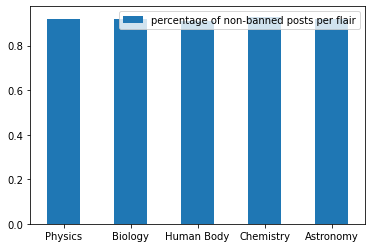

In [61]:
author_cumsum = np.cumsum(text_submissions_raw.loc[:,'author'].value_counts())
##Authors appear to be from a wide variety of people, 1/10 of posts are from deleted accounts
# This could possibly be from bot spam, we can verify from other subreddits or from time distribution of
# these deleted accounts whether they are likely to be from bots
# There doesn't appear to be any meaningful value to be gleaned from this feature without prehaps correlating the topics
# of the users previous posts to guess their current post, however we don't have access to this data
print('Value counts posts by author:')
print(text_submissions_raw.loc[:,'author'].value_counts())
print()
plt.plot(np.argsort(author_cumsum), author_cumsum, 'g-')
plt.xlabel("Cumlative Counts of Post")
plt.ylabel("Number of Posts by a single author")
plt.title('Cumulative sum of number of post on r/AskScience by number of posts by a single author')
plt.show()


# Author FullName is hashed and will not provide value
print('author_fullname samples: ')
print(text_submissions_raw.loc[:,'author_fullname'].head(3))
print()

print('Contest_Mode values: ')
# r/AskScience doesn't use contests, as all values are null or False so this feature provides no value
print((text_submissions_raw.loc[:,'contest_mode'].value_counts()))
print()

# We can remove ID as it provides no meaning and is just a way of organizing and linking the posts
print('id samples: ')
print((text_submissions_raw.loc[:,'id'].head(3)))
print()

# Full link provides no info it only contains the subreddit r/AskScience which every datapoint in the dataset is from and 
# the question which is asked, which is already in the question column
print('full_link samples: ')
print((text_submissions_raw.loc[:,'full_link'].head(3)))
print()

# A large portion of the data is shown to be true, so we can get very little value out of this feature
# Also semantically it is hard to see any clear relation to the topic of the post
print('is_self values: ')
print(text_submissions_raw.loc[:,'is_self'].value_counts())
print()

#A large portion of the data is shown to be false, so we can get very little value out of this feature
# Also semantically it is hard to see any clear relation to the topic of the post
print('locked values count: ')
print(text_submissions_raw.loc[:,'locked'].value_counts())
print()

#Simillar to full link samples, this provides no meaningful new information
print('permalink sample: ')
print(text_submissions_raw.loc[:,'permalink'].head(3))
print()

#A large portion of the data is shown to be false, so we can get very little value out of this feature
# Also semantically it is hard to see any clear relation to the topic of the post
print('spoiler values: ')
print(text_submissions_raw.loc[:,'spoiler'].value_counts())
print()

#A large portion of the data is shown to be false, so we can get very little value out of this feature
# Also semantically it is hard to see any clear relation to the topic of the post
print('stickied values: ')
print(text_submissions_raw.loc[:,'stickied'].value_counts())
print()

# This features information is contained in the other features already(is_self, spoiler,18+) and so isn't needed
print('thumbnail values: ')
print(text_submissions_raw.loc[:,'thumbnail'].value_counts())
print()


# Simillar to full link samples, this provides no meaningful new information
print('url sample:' )
print(text_submissions_raw.loc[:,'url'].head(3))
print()

# Although domain may be a good indicator of the topic since it links to domain specific subreddits, >99.9% of the post's
# This indicates we would likely want to remove this feature.
print('percent of posts under each domain:')
print((text_submissions_raw.loc[:,'domain'].value_counts()/np.sum(text_submissions_raw.loc[:,'domain'].value_counts())).head(3))
print()

# A little under 10% of posted have been banned its possible some topics tend to get more than others
# Reasons for banning for r/AskScience fall under posts who don't follow the follwing rules:
#  • State your question succinctly in the title and include a question mark.
#  • No simple calculations are allowed.
#  • If the question can be answered with a Google search, it is not appropriate for r/AskScience.
#  • Questions must be in the form of full sentences. For example, "black holes?" will not be accepted.
#  • Again, no medical advice or personal anecdotes are allowed.
#  • This community is not here to answer your homework or research questions. Do your own work.
#  • No hypothetical questions.
#  • Avoid questions on personal or isolated events.
print('banned counts: ')
print(text_submissions_raw.loc[:,'banned'].value_counts())
print(text_submissions_raw)
print()
top_flairs = list(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[0:5].keys())
count_of_banned = []
for flair in top_flairs:
    size = text_submissions_raw.loc[text_submissions_raw['link_flair_text'] == flair].shape[0]
    count = text_submissions_raw.loc[text_submissions_raw['link_flair_text'] == flair].loc[:,'banned'].value_counts()[0]
    count_of_banned.append(np.divide(count,size))

print('We see each flair is roughly the same amount of banned posts')
df = pd.DataFrame({'percentage of non-banned posts per flair': count_of_banned}, index=top_flairs)
ax = df.plot.bar(rot=0)
print(ax)

Archaeology                                     978
Biology/Agriculture                               5
Neuroscience AMA                                  3
Agriculture                                       2
Malaria AMA                                       2
ACS AMA                                           2
Panel Applications                                2
Climate Science AMA                               1
Neutrino Physics AMA                              1
Botany                                            1
Psychology AMA                                    1
Meta                                              1
Doggies 🐶                                         1
Climate History AMA                               1
Ocean Research AMA                                1
Biology/forestry                                  1
Genetic Medicine                                  1
Synthetic Biology AMA                             1
NOAA | The Rising Risk of Whale Entanglement      1
Earth Scienc

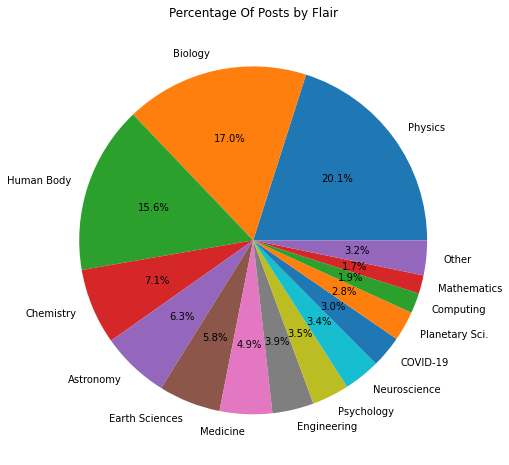

In [62]:
flair_count_other.plot.pie(label='', title="Percentage Of Posts by Flair", legend=False, autopct='%1.1f%%', figsize=(10, 8))
print(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[20:])


We see 62 unique flair types only 11 over 3%, only 19 over 10000 posts and 41 flairs which have only less than 5 posts


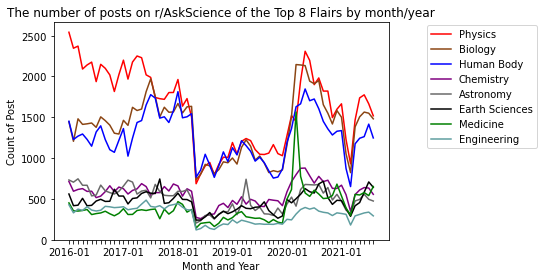

In [63]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

top_flairs = list(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[0:8].keys())
top_flair_authors = text_submissions_raw
top_flair_authors = top_flair_authors.loc[top_flair_authors['link_flair_text'].isin(top_flairs)]

fig,axes=plt.subplots(1,1)

plt.title("The number of posts on r/AskScience of the Top 8 Flairs by month/year")
plt.xlabel("Month and Year")
plt.ylabel("Count of Post")
colors = ['red','saddlebrown','blue','purple', 'dimgray', 'black', 'green', 'cadetblue', 'firebrick','plum']
color_map = {}
for flair in top_flairs:
    color_map[flair] =  colors.pop(0)   

date_range = np.sort(top_flair_authors['created_utc'].unique())[1:]

for flair in top_flairs:
    y = top_flair_authors.loc[top_flair_authors['link_flair_text'] == flair,'created_utc'].value_counts()
    if y.size < 6:
        ser = pd.Series([0 for i in range(70-y.size)])
        y = ser.append(y)
    axes.plot(date_range, y.sort_index()[1:], color=color_map[flair], label=flair)
plt.legend(bbox_to_anchor=(1.1, 1.01))

for i, tick in enumerate(axes.xaxis.get_ticklabels()):
    if i % 12 != 0:
        tick.set_visible(False) 

plt.show()
fig.savefig('fig2.png', dpi = 300)


Looking at the number of posts over time, the subreddit lost a lot of popularity in 2018 and 2019, but then gained a resurgence in 2020 and is maintaining the popularity in 2021.

The huge spike in popularity coincides with lockdowns starting to occur in North America in early to mid 2020. This would suggest like a lot of internet-based media r/AskScience saw a huge boost in activity from covd-19 lockdown. We even see a new flair COVID-19 popup in 2019 and quickly rise to 3% all time popularity in less than 2 years

Looking at the topmost used flairs we see a surprisingly consistent pattern between distribution of flair types over time. Flairs tend to fall and grow at the same time but also maintain close to the same relative popularity. We see almost two groups in the top flairs, the ‘dominant flairs’ Physics, Biology and Human Body which maintain them top 3 status and are close together, and then the second group of a wide variety of topics like Chemistry, Engineering, and Astronomy which maintain a ‘middle tier’ group which all stay roughly together with neither group really jumping between.

There is a noteworthy spike from medicine in 2020 which breaks this pattern which is likely due to the sudden public interest in covid’s health measures and the vaccine. This demonstrates that although the subreddit is relatively set in its ways, massive events like the corona virus can be reflect in large scale change in the behavior of the subreddit.

In [64]:
author_gt_n = text_submissions_raw.loc[:,'author'].value_counts()> 0
top_flairs = list(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[0:8].keys())
top_flair_authors = text_submissions_raw.loc[text_submissions_raw['author'].isin(author_gt_n[1:].index)]
top_flair_authors = top_flair_authors.loc[top_flair_authors['link_flair_text'].isin(top_flairs)]
top_flair_authors = top_flair_authors.loc[top_flair_authors['author'].isin(author_gt_n.index)]
top_flair_authors = top_flair_authors.sort_values(by=['author'])
top_flair_authors = top_flair_authors.reset_index(drop=True)


## n unique topics per num posts
## correlation between topics and poster
author_topic = {}
for c, c_row in top_flair_authors.iterrows():
    i = 1
    if (c+i) not in top_flair_authors.index:
            break
    author = c_row['author']
    flair = c_row['link_flair_text']
    next_author = top_flair_authors.iloc[c+i, :].loc['author']
    next_flair = top_flair_authors.iloc[c+i, :].loc['link_flair_text']
    next_score = top_flair_authors.iloc[c+i, :].loc['score']
    if author not in author_topic.keys():
        author_topic[author] = {}
        author_topic[author]['total'] = 1
        author_topic[author]['score'] = c_row['score']
    if flair not in author_topic[author].keys():
        author_topic[author][flair] = 1
    else :
        author_topic[author][flair] = author_topic[author][flair] +1
        author_topic[author]['total'] = author_topic[author]['total'] +1
        author_topic[author]['score'] = author_topic[author]['score'] + next_score
    while(author == next_author):
        if next_flair not in author_topic[author]:
            author_topic[author][next_flair] = 1
        else :
            author_topic[author][next_flair] = author_topic[author][next_flair]+1
        author_topic[author]['total'] = author_topic[author]['total']+1
        author_topic[author]['score'] = author_topic[author]['score'] + next_score
        i+= 1
        if (c+i) in top_flair_authors.index:
            next_author = top_flair_authors.iloc[c+i, :].loc['author']
            next_flair = top_flair_authors.iloc[c+i, :].loc['link_flair_text']
            next_score = top_flair_authors.iloc[c+i, :].loc['score']
        else:
            break
    
flair_count = pd.DataFrame(data=author_topic).T.fillna(0)
        

Generates a table of all posters, calculating the number of times they posted in each flair type and thier total cumlative score

In [73]:
## These function are NOT MY WORK -> ttps://wil.yegelwel.com/cluster-correlation-matrix/
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

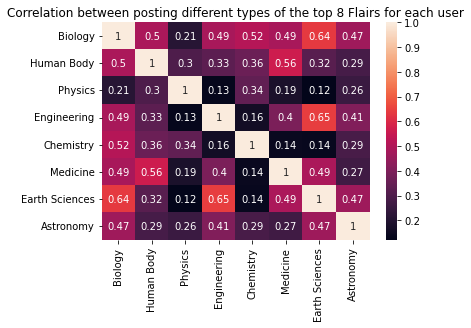

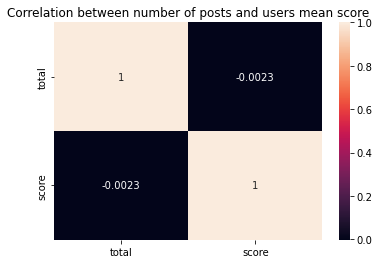

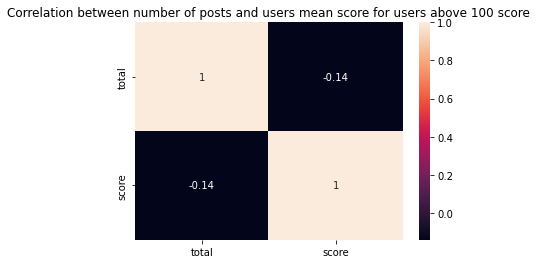

In [77]:
#user corrleation with posts
corrMatrix = flair_count.iloc[:,2:len(top_flairs)+2].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation between posting different types of the top 8 Flairs for each user')
plt.show()

flair_count.iloc[:,1] =  flair_count.iloc[:,1]/flair_count.iloc[:,0]
flair_count =  flair_count.loc[flair_count['score']>=0, :]

#correlation between mean score and number of posts all
corrMatrix = flair_count.iloc[:,0:2].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title('Correlation between number of posts and users mean score')
plt.show()

#correlation between mean score and number of posts top
# actually majority of posts are one hit wonders so posting 
# more is actually slightly correlated with decrease your score
x = flair_count.iloc[:,0:2] 
x = x.loc[x['score'] > 100]
corrMatrix = x.corr()
plt.title('Correlation between number of posts and users mean score for users above 100 score')
sns.heatmap(corrMatrix, annot=True)
plt.show()




Looking at the correlation between types of posts (based on flair) by user we see specific flair grouping which tend to be posted by the same person are biology, earth science and engineering. Physics also seems to be uniquely separate from the other flairs not having high correlation with any other flair. Biology has the highest correlation with every other flair, which makes sense from the most widely used flair and we also see a tight correlation between engineering, earth science and biology

Looking at the correlation between score and total we see that their is actually a negative correlation between mean score and total number of posts. This even stands true for people with over 100 score. This would suggest that it is usually the case that score generally comes from one post, rather than consistently posting and getting high scores throughout

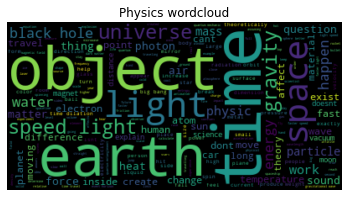

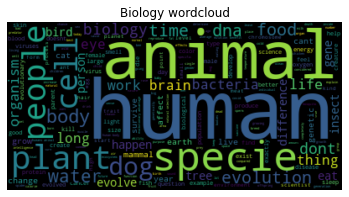

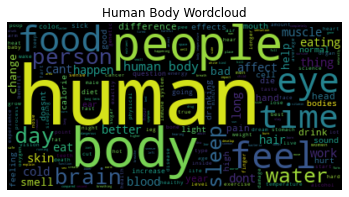

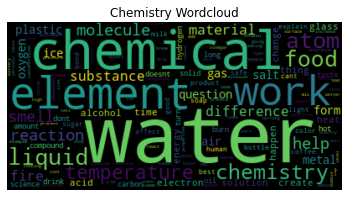

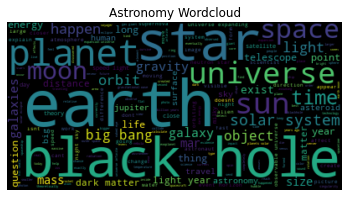

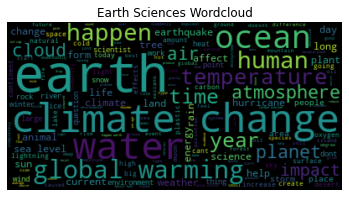

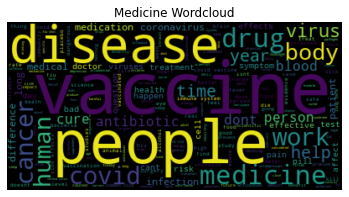

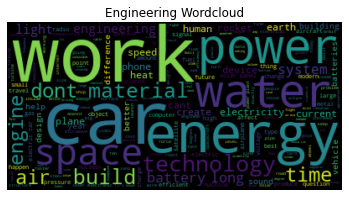

In [79]:
## Look at common words for each cluster
img_dict ={}

from wordcloud import WordCloud
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

text_physics = x_train.loc[y_train == 'Physics']['question']
text_physics_join = " ".join(review for review in text_physics)
wordcloud = WordCloud().generate(text_physics_join)
img_dict[0] = wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Physics wordcloud')
plt.show()

text_biology = x_train.loc[y_train == 'Biology']['question']
text_biology_join = " ".join(review for review in text_biology)
wordcloud = WordCloud().generate(text_biology_join)
img_dict[1] = wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Biology wordcloud')

plt.show()

text_body = x_train.loc[y_train == 'Human Body']['question']
text_body_join = " ".join(review for review in text_body)
wordcloud = WordCloud().generate(text_body_join)
img_dict[2] = wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Human Body Wordcloud')

plt.show()

text_chemistry = x_train.loc[y_train == 'Chemistry']['question']
text_chemistry_join = " ".join(review for review in text_chemistry)
wordcloud = WordCloud().generate(text_chemistry_join)
plt.imshow(wordcloud, interpolation='bilinear')
img_dict[3] = wordcloud

plt.axis("off")
plt.title('Chemistry Wordcloud')
plt.show()

text_astronomy = x_train.loc[y_train == 'Astronomy']['question']
text_astronomy_join = " ".join(review for review in text_astronomy)
wordcloud = WordCloud().generate(text_astronomy_join)
img_dict[4] = wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Astronomy Wordcloud')

plt.show()

text_astronomy = x_train.loc[y_train == 'Earth Sciences']['question']
text_astronomy_join = " ".join(review for review in text_astronomy)
wordcloud = WordCloud().generate(text_astronomy_join)
img_dict[5] = wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Earth Sciences Wordcloud')

plt.show()

text_astronomy = x_train.loc[y_train == 'Medicine']['question']
text_astronomy_join = " ".join(review for review in text_astronomy)
img_dict[6] = wordcloud

wordcloud = WordCloud().generate(text_astronomy_join)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Medicine Wordcloud')

plt.show()

text_astronomy = x_train.loc[y_train == 'Engineering']['question']
text_astronomy_join = " ".join(review for review in text_astronomy)
wordcloud = WordCloud().generate(text_astronomy_join)
img_dict[7] = wordcloud

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Engineering Wordcloud')

plt.show()


We see that each flair has pretty distinct words that coincide with that branch of science, however some words overlap. For example 'earth' is used in astronomy and earth sciences and physics, 'human' is a common word between human body, medicine, and biology.

'Energy','earth','work', 'light' are all terms used in both physics and engineering. This suggests these topics are indeed very similar in subject matter, however they do have some distinction as well

First, we will take the raw question data and remove any stop words/uninformative wards, punctuation/non alpha characters, and lowercase everything. Stemming was applied but found not significant predicative improvements. This will be our corpus for analysis. For the purpose of analysis we will only look at the top 8 flairs, for easy of analysis and computation, but also all lower flairs are only used less than 4% of the time. Then the data is split between training(60%), validation(15%) and testing(30%)

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS


# clean and split data
from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()
custom_stop = set(["the", "a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep    keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure    t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z"])
top_flairs = list(text_submissions_raw.loc[:,'link_flair_text'].value_counts()[0:8].keys())
text_submissions_raw_filtered = text_submissions_raw[text_submissions_raw['score'] >=0]
text_submissions = text_submissions_raw_filtered[text_submissions_raw_filtered['link_flair_text'].isin(top_flairs)]
flair = text_submissions['link_flair_text']
text_submissions = text_submissions.drop('link_flair_text', axis=1)
nltk_stop = stopwords.words('english')
stop = list(set().union(nltk_stop, custom_stop))
text_submissions_preprocessed = text_submissions
text_submissions_preprocessed['question'] = text_submissions_preprocessed['question'].apply(lambda x: ' '.join([''.join(filter(str.isalpha, word)) for word in x.lower().split()]))
text_submissions_preprocessed['question'] = text_submissions_preprocessed['question'].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in (stop) and (len(word)>2)]))


x_train, x_test, y_train, y_test = train_test_split(text_submissions_preprocessed, flair, test_size=0.6, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

Then using TFIDF the training data is then fitted and applied and then passed through both Multinomial Naive Bayes classifier and a Linear Support Vector Classifier, which is then fined tuned with the validation set and applied to the test set

We see the accuracy of MultinomialNB is 0.65 and LinearSVC 0.668 (may change slighly based on randomization)

In [83]:
#apply tfidf and then Naive Bayes and SVC

train_question_corpus = x_train['question']
vectorizer = TfidfVectorizer(max_df = 0.9, min_df=3, max_features=9000, ngram_range=(1,2))
tfidf_vector = vectorizer.fit_transform(train_question_corpus)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=train_question_corpus, columns=vectorizer.get_feature_names())
idf_df = pd.DataFrame(list(zip(vectorizer.get_feature_names(), vectorizer.idf_)), columns = ['word', 'idf'])

from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

test_question_corpus = x_test['question']
val_question_corpus = x_val['question']
x_test_tfidf_vector = vectorizer.transform(test_question_corpus)
x_val_tfidf_vector = vectorizer.transform(val_question_corpus)

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(tfidf_vector, y_train)
y_pred_val = naive_bayes_classifier.predict(x_val_tfidf_vector)
score_val = metrics.accuracy_score(y_val, y_pred_val)
y_pred_test = naive_bayes_classifier.predict(x_test_tfidf_vector)
score_test = metrics.accuracy_score(y_test, y_pred_test)
print('Val score: ', score_val)
print('Test score: ', score_test)

clf = LinearSVC(random_state=0)
clf.fit(tfidf_vector,y_train)
y_val_pred=clf.predict(x_val_tfidf_vector)
y_test_pred=clf.predict(x_test_tfidf_vector)
report_val=classification_report(y_val, y_val_pred,output_dict=True)
report_test=classification_report(y_test, y_test_pred,output_dict=True)
print('Val report: ', report_val)
print('Test report: ', report_test)

Val score:  0.6419050084120616
Test score:  0.6438264358147145
Val report:  {'Astronomy': {'precision': 0.6911346987591568, 'recall': 0.6290651789359096, 'f1-score': 0.6586408320273542, 'support': 7349}, 'Biology': {'precision': 0.6919492902806371, 'recall': 0.6509683995922528, 'f1-score': 0.6708335521823626, 'support': 19620}, 'Chemistry': {'precision': 0.6055953155497723, 'recall': 0.5684621961646513, 'f1-score': 0.5864415322580645, 'support': 8187}, 'Earth Sciences': {'precision': 0.6753562738964198, 'recall': 0.581301421091997, 'f1-score': 0.624809068253075, 'support': 6685}, 'Engineering': {'precision': 0.531557247066286, 'recall': 0.36916299559471366, 'f1-score': 0.4357207851293383, 'support': 4540}, 'Human Body': {'precision': 0.6251237868884928, 'recall': 0.7075603878271591, 'f1-score': 0.6637924235652882, 'support': 17843}, 'Medicine': {'precision': 0.5795254833040422, 'recall': 0.4785921625544267, 'f1-score': 0.5242448330683624, 'support': 5512}, 'Physics': {'precision': 0.67

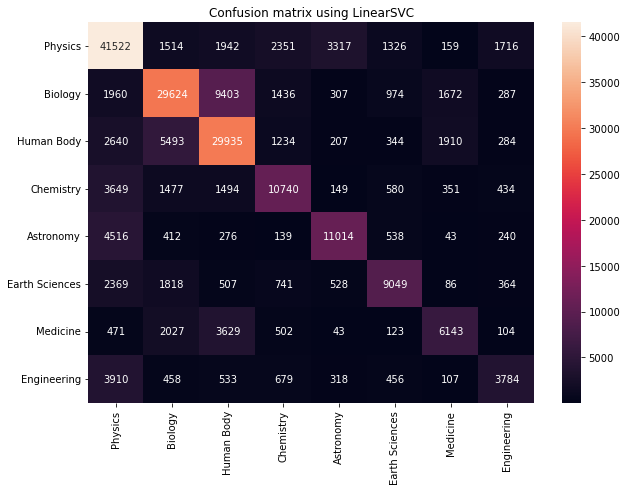

In [85]:
from sklearn.metrics import  confusion_matrix

conf_mat = confusion_matrix(
        y_test, y_test_pred, labels = ['Physics',
 'Biology',
 'Human Body',
 'Chemistry',
 'Astronomy',
 'Earth Sciences',
 'Medicine',
 'Engineering'])
plt.figure(figsize = (10,7))

x_axis_labels = ['Physics',
 'Biology',
 'Human Body',
 'Chemistry',
 'Astronomy',
 'Earth Sciences',
 'Medicine',
 'Engineering'] # labels for x-axis
y_axis_labels = ['Physics',
 'Biology',
 'Human Body',
 'Chemistry',
 'Astronomy',
 'Earth Sciences',
 'Medicine',
 'Engineering'] # labels for y-axis
plt.title('Confusion matrix using LinearSVC')
sns.heatmap(conf_mat, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True,  fmt='g')



Looking at the confusion matrix of the LinearSVC model we can analyze topics which the model could easily predict, and which it had trouble distinguishing.

We see high similarity by the predictor between Biology and Human Body in both directions which makes sense since they have similar domains.

Human body is more than twice as likely to be mistaken for medicine, compared to biology to be mistake for medicine. We also see engineering posts are often predicted to be physics posts, whereas physics posts are not so often mislabeled as engineering We also see most other flairs are often mislabeled as Physics flairs These results suggest that prehaps Biology and Human Body flairs could be combined.

The problem with this is that these two flairs are already among the biggest flairs, so it is possible the very close similarity is endured to maintain slightly between distinction between the posts

The commonalities between the misclassification is reflected in the similarity of the confusion matrix of our classifier and the previous word clouds

In [87]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=5)

# apply transformation
tf = vectorizer.fit_transform(x_train['question']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

no_top_words = 25
t = display_topics(model, tf_feature_names, no_top_words)


Using a matrix of word counts from the training set LatentDirichletAllocation (LDA) is used to determine weights for each new topic. 

For each category we see the topics are: Biology, Physics, Zoology, AstroPhysics, Medicine, Earth Science, Human Body, Chemistry


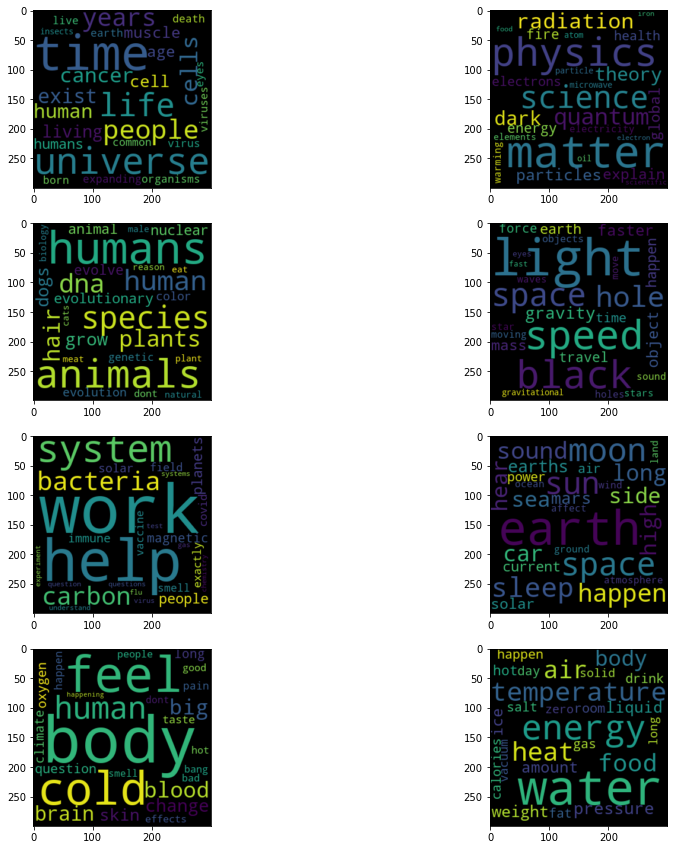

In [88]:

from wordcloud import WordCloud
img_dict= {}
t = display_topics(model, tf_feature_names, no_top_words)
img_dict[0]  = dict(zip(t['Topic 0 words'], t['Topic 0 weights'].astype(float)))
img_dict[1]  = dict(zip(t['Topic 1 words'], t['Topic 2 weights'].astype(float)))
img_dict[2]  = dict(zip(t['Topic 2 words'], t['Topic 2 weights'].astype(float)))
img_dict[3]  = dict(zip(t['Topic 3 words'], t['Topic 3 weights'].astype(float)))
img_dict[4]  = dict(zip(t['Topic 4 words'], t['Topic 4 weights'].astype(float)))
img_dict[5]  = dict(zip(t['Topic 5 words'], t['Topic 5 weights'].astype(float)))
img_dict[6]  = dict(zip(t['Topic 6 words'], t['Topic 6 weights'].astype(float)))
img_dict[7]  = dict(zip(t['Topic 7 words'], t['Topic 7 weights'].astype(float)))

rows=4
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
        if img_count < 8:
            wc = WordCloud(background_color='black', width = 300, height=300, margin=2)
            wc_fit = wc.fit_words(img_dict[img_count])
            axes[i, j].imshow(wc_fit, interpolation='bilinear')
            img_count+=1
print('For each category we see the topics are: Biology, Physics, Zoology, AstroPhysics, Medicine, Earth Science, Human Body, Chemistry')


Looking at the new topics we see a lot of the existing topics clearly from the word clouds. Chemistry, Physics, AstroPhysics/Astronomy, Chemistry and Earth Sciences. We also have some word clouds that are a bit ambiguous like Medicine, Human Body and Biology. None of these seem like perfect fits but are the best approximations of the words.

Zoology is a new topics which is now seen. It has words specific to studying animals(including humans): Plants, hair, evolutionary, species, dogs, animals.

#### Next steps?
Given more time, I think the next natural step would be to include this new topic of Zoology and relabel posts from the subreddit and try to rerun a topic classification prediction model on the new data and see if it performs better. Naturally using only models to verify how well these topics are labelled has very little external validity so having manual labelers and validators would be ideal once our model is able to easily determine the distinction in topics

